In [1]:
# Cálculo de algunas características fisiográficas de cuencas.

import numpy as np
import pandas as pd

from scipy import optimize
from scipy import integrate

from matplotlib import pyplot as plt

import geopandas as gpd

In [2]:
# Dirección de los datos.
path = "../Material/Clases/Clase 7/"

# Nombres de las cuencas.
nombres_sub = ["RH12Ai_subc.shp", "RH19Be_subc.shp"]
nombres_c   = ["RH12Ai_curvas.shp", "RH19Be_curvas.shp"]
nombres_r   = ["Río San Fernando.shp", "Coords Río San Fernando.shp"]
#nombres_r   = ["Río Sonora.shp", "Coords Río Sonora.shp"]

# Lista con las cuencas.
# Creamos una lista vacía que llenaremos luego
Cuencas = [None, None]
Curvas  = [None, None]
Rios    = [None, None]

In [3]:
# Abrimos la primera subcuenca.
i = 0

Cuencas[i] = gpd.read_file(path + nombres_sub[i])

# A coordenadas UTM 14N (m).
Cuencas[i] = Cuencas[i].to_crs(32614)

# Datos.
print(Cuencas[i].loc[0])

# Forma de la cuenca.
Cuencas[i].explore()

ID                                                        303.0
CVE_SUBCUE                                               RH12Ai
CVE_RH                                                     RH12
RH                                             LERMA - SANTIAGO
CVE_CUE                                                       A
CUENCA                                        R. LERMA - TOLUCA
CVE_SUBC                                                      i
SUBCUENCA                                              R. Gavia
AREA_KM2                                                 579.87
PERIMETRO                                                119.92
TIPO                                                    ABIERTA
DRENAJE1                                                 RH12Ab
DESCARGA1                                                     1
DRENAJE2                                                      -
DESCARGA2                                                     0
DRENAJE3                                

In [4]:
# Abrimos la segunda subcuenca.
i = 1

Cuencas[i] = gpd.read_file(path + nombres_sub[i])

# A coordenadas UTM 14N (m).
Cuencas[i] = Cuencas[i].to_crs(32614)

# Datos.
print(Cuencas[i].loc[0])

# Forma de la cuenca.
Cuencas[i].explore()

ID                                                        155.0
CVE_SUBCUE                                               RH19Be
CVE_RH                                                     RH19
RH                                                 COSTA GRANDE
CVE_CUE                                                       B
CUENCA                                    R. COYUQUILLA Y OTROS
CVE_SUBC                                                      e
SUBCUENCA                                           R. Petatlán
AREA_KM2                                                 548.64
PERIMETRO                                                142.88
TIPO                                                    ABIERTA
DRENAJE1                                                 RH19Bf
DESCARGA1                                                     1
DRENAJE2                                                      -
DESCARGA2                                                     0
DRENAJE3                                

In [5]:
# Coeficiente de compacidad de Gravelius.

# El primer corchete escoge el primer elemento
# de la lista Cuencas, que es el geoDataFrame
# de la subcuenca R. Gavia. El segundo corchete 
# crea la columna Gravelius dentro del GeoDataFrame.
# Si una operación está dentro de un paréntesis, la
# podemos escribir a lo largo de varias filas.
# Dentro de dobles comillas, hay que poner comillas sencillas.
for i in range( len(Cuencas) ):
    Cuencas[i]["GRAVELIUS"] = ( Cuencas[i]["PERIMETRO"] /
        ( 2 * np.sqrt( np.pi * Cuencas[i]["AREA_KM2"] ) ) )
    
    print( "Gravelius subcuenca "
        + f"{Cuencas[i].loc[0, 'SUBCUENCA']}: "
        + f"{Cuencas[i].loc[0, 'GRAVELIUS']}" )

Gravelius subcuenca R. Gavia: 1.4048222187279467
Gravelius subcuenca R. Petatlán: 1.7207698007667973


       LENGTH   COV_  COV_ID  CONTOUR  \
70   1.652969  80774   44598      201   
68  16.434123  80772   44598      201   
67  10.770701  80771   44598      201   
69  17.849448  80773   44598      201   
60   6.583120  78308   44368      401   
23   0.518248  52669   40091      401   
62  16.298459  78310   44368      401   
61  16.973425  78309   44368      401   
64  16.582812  78312   44368      401   
65  16.405409  78313   44368      401   

                                             geometry  
70  LINESTRING (263788.726 1940519.020, 264147.233...  
68  LINESTRING (260134.762 1946798.667, 259968.703...  
67  LINESTRING (255671.531 1951058.875, 255937.259...  
69  LINESTRING (268919.978 1946682.515, 269334.421...  
60  LINESTRING (257092.517 1951138.962, 257222.981...  
23  LINESTRING (272432.371 1946065.153, 272328.854...  
62  LINESTRING (268224.169 1948843.659, 268233.608...  
61  LINESTRING (261122.248 1948792.180, 261186.287...  
64  LINESTRING (278480.666 1953632.296, 2784

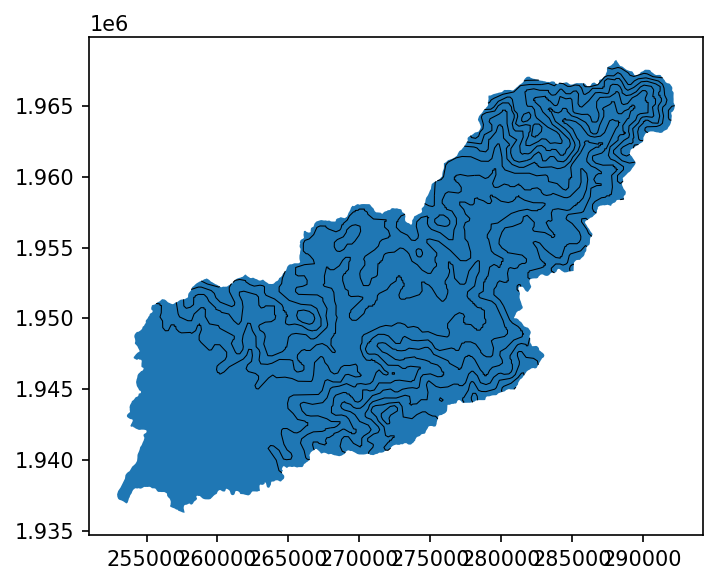

In [6]:
# Curvas de nivel.

# Cargamos los valores.
for i in range( len( Curvas ) ):
    Curvas[i] = gpd.read_file(path + nombres_c[i])
    # A coordenadas UTM 14N (m).
    Curvas[i] = Curvas[i].to_crs(4487)
    # Las curvas son un recorte de unas más largas.
    # La longitud no es real y hay que recalcularla.
    Curvas[i]["LENGTH"] = Curvas[i].length / 1000

# Ordenamos por cota para verificar Δz.
# El argumento de head es la cantidad de filas a poner.
print( Curvas[i].sort_values("CONTOUR").head(10) )

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_dpi(150) 

Cuencas[i].plot(ax = ax)
Curvas[i].plot(ax = ax, color = "k", linewidth = 0.5)

fig.tight_layout()

In [7]:
# Pendiente de la cuenca de Alvard.

# Desnivel entre curvas [km]
D = 0.2

for i in range( len( Cuencas ) ):
    Cuencas[i]["ALVARD"] = ( D * Curvas[i]["LENGTH"].sum()
        / Cuencas[i]["AREA_KM2"] )
    
    # Pendiente en m/km.
    print( "Alvard subcuenca "
        + f"{Cuencas[i].loc[0, 'SUBCUENCA']}: "
        + f"{Cuencas[i].loc[0, 'ALVARD'] * 1000}" )

Alvard subcuenca R. Gavia: 69.81851468863245
Alvard subcuenca R. Petatlán: 243.80207491186428


In [8]:
# Cargamos la información del Río San Fernando.

for i in range( len(Rios) ):
    Rios[i] = gpd.read_file(path + nombres_r[i])
    # Mexico ITRF92 UTM 14N.
    Rios[i] = Rios[i].to_crs(4487)

# Vector del río.
print( Rios[0] )
print()
# Nube de puntos con información de cotas.
print( Rios[1].head() )

   FNODE_  TNODE_  LPOLY_  RPOLY_   LENGTH  COV_  COV_ID          NOMBRES  \
0    2606    2607       0       0  0.59233  1787    1967        R. Potosi   
1    2605    2608       0       0  0.93024  1788    1967       R. Conchos   
2    2600    2601       0       0  1.15536  1794    1962  R. San Fernando   

                                            geometry  
0  LINESTRING (466696.307 2758737.615, 462081.066...  
1  LINESTRING (543202.323 2777371.938, 543561.925...  
2  LINESTRING (631716.879 2760990.414, 631083.156...  

   FNODE_  TNODE_  LPOLY_  RPOLY_   LENGTH  COV_  COV_ID     NOMBRES  \
0    2605    2608       0       0  0.93024  1788    1967  R. Conchos   
1    2605    2608       0       0  0.93024  1788    1967  R. Conchos   
2    2605    2608       0       0  0.93024  1788    1967  R. Conchos   
3    2605    2608       0       0  0.93024  1788    1967  R. Conchos   
4    2605    2608       0       0  0.93024  1788    1967  R. Conchos   

   distance       angle     xcoord   

In [9]:
# Despalazamos las coordenadas un lugar.
gs = Rios[1]["geometry"].shift(1)
# Calculamos la distancia entre dos puntos adyacentes.
Rios[1]["Distancia"] = Rios[1]["geometry"].distance(gs)
# La posición del primer punto es 0, para los demás es una suma acumulada.
Rios[1].loc[0, "Distancia"] = 0
Rios[1]["x"] = Rios[1]["Distancia"].cumsum()

# Guardamos la distancia y la cota en otras variables.
x = Rios[1]["x"]
z = Rios[1]["zcoord"]

# Escogemos los valores iniciales y finales.
x_i = x.to_numpy()[0]
x_f = x.to_numpy()[-1]
z_f = z.to_numpy()[-1]
z_i = z.to_numpy()[0]

Rios[1]

,FNODE_,TNODE_,LPOLY_,RPOLY_,LENGTH,COV_,COV_ID,NOMBRES,distance,angle,xcoord,ycoord,zcoord,Distancia,x,geometry
0,2605,2608,0,0,0.93024,1788,1967,R. Conchos,0.93,246.784079,-99.328513,24.944138,233.0,0.000000,0.000000,POINT (466834.720 2758802.322)
1,2605,2608,0,0,0.93024,1788,1967,R. Conchos,0.92,267.382556,-99.319082,24.947030,225.0,1004.528814,1004.528814,POINT (467787.592 2759120.305)
2,2605,2608,0,0,0.93024,1788,1967,R. Conchos,0.91,267.382556,-99.309093,24.947487,222.0,1009.753687,2014.282501,POINT (468796.193 2759168.540)
3,2605,2608,0,0,0.93024,1788,1967,R. Conchos,0.90,267.382556,-99.299103,24.947943,219.0,1009.749188,3024.031689,POINT (469804.786 2759216.849)
4,2605,2608,0,0,0.93024,1788,1967,R. Conchos,0.89,267.382556,-99.289114,24.948400,225.0,1009.744714,4033.776403,POINT (470813.370 2759265.232)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,2600,2601,0,0,1.15536,1794,1962,R. San Fernando,0.04,252.988083,-97.727834,24.940236,-8.0,1018.530522,211847.408317,POINT (628442.764 2758931.559)
206,2600,2601,0,0,1.15536,1794,1962,R. San Fernando,0.03,254.948968,-97.718223,24.942993,8.0,1017.389383,212864.797699,POINT (629410.356 2759245.959)
207,2600,2601,0,0,1.15536,1794,1962,R. San Fernando,0.02,254.948968,-97.708566,24.945590,10.0,1016.648970,213881.446669,POINT (630382.710 2759542.779)
208,2600,2601,0,0,1.15536,1794,1962,R. San Fernando,0.01,209.974830,-97.700212,24.949882,9.0,968.269174,214849.715843,POINT (631221.644 2760026.240)


In [10]:
# Recta de compensación.
def rect_comps(z_r):
    z = (z_f - z_r ) / (x_f - x_i) * (x - x_f) + z_f
    return z

# Integral de áreas compensadas.
def area_comps(z_r):
    a = rect_comps(z_r)
    I = integrate.simpson(z - a)
    return I
    

Pendiente [m/km]: [0.66735957]


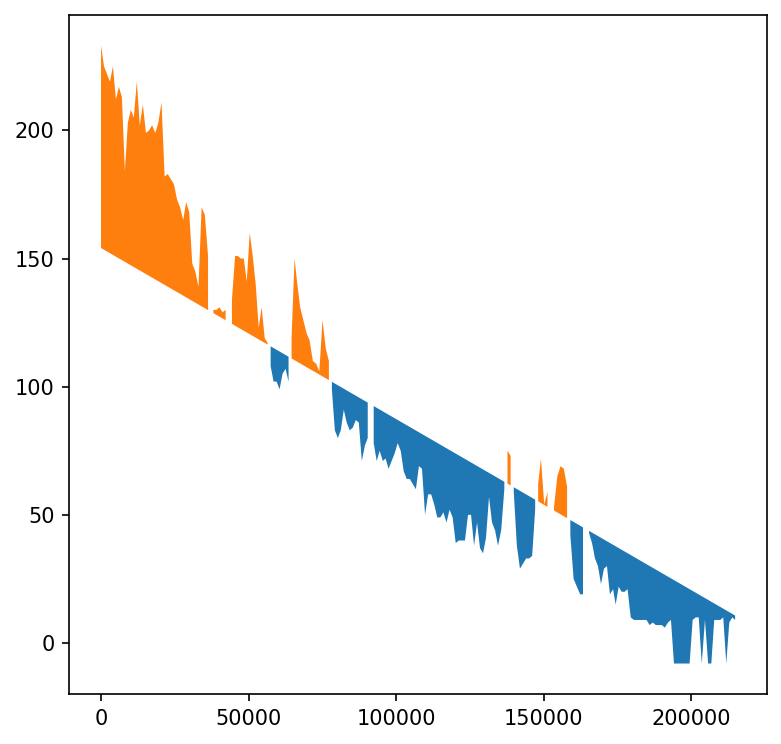

In [11]:
# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Graficamos el perfil del río.
#ax.plot(x, z)

# Encontramos la cota z_r que compensa las áreas.
# Primer intento: z_i
z_r = optimize.fsolve(area_comps, x0 = z_i)

# Graficamos la recta compensada.
z_2 = rect_comps(z_r)
#ax.plot(x, z_2)

# Dibujamos las áreas compensadas.
ax.fill_between( x, z, z_2, where = z < z_2 )
ax.fill_between( x, z, z_2, where = z > z_2 )

# Pendiente.
S = (z_r - z_f ) / (x_f - x_i)
print(f"Pendiente [m/km]: {S * 1000}")

In [12]:
# Tarea:
# 1. calcular la pendiente para el río Sonora por
# desnivel medio y por áreas compensadas y comparar.
# Utilizar UTM 12N (m) EPSG:4485 (https://epsg.io/4485)
# 2. Para la subcuenca R. Petatlán calcula la densidad
# de corrientes y la densidad de drenaje.

In [13]:
'''
# Ajustes shapefile río San Fernando.

Rios[1]["zcoord"] = np.nansum( [ Rios[1]["SAMPLE_1"],
    Rios[1]["SAMPLE_1_2"] ], axis = 0 )
Rios[1].drop(["SAMPLE_1", "SAMPLE_1_2"], axis = 1, inplace = True)

s_fer   = Rios[1][Rios[1]["NOMBRES"] == "R. San Fernando"].sort_values(
    "distance", ascending = False)
conchos = Rios[1][Rios[1]["NOMBRES"] == "R. Conchos"].sort_values(
    "distance", ascending = False)
potosi  = Rios[1][Rios[1]["NOMBRES"] == "R. Potosi"].sort_values(
    "distance", ascending = False)

Rios[1] = pd.concat( [conchos, s_fer], axis = 0 )
Rios[1].reset_index(drop = True, inplace = True)

Rios[1].to_file(path + "Coords Río San Fernando.shp")
'''

'\n# Ajustes shapefile río San Fernando.\n\nRios[1]["zcoord"] = np.nansum( [ Rios[1]["SAMPLE_1"],\n    Rios[1]["SAMPLE_1_2"] ], axis = 0 )\nRios[1].drop(["SAMPLE_1", "SAMPLE_1_2"], axis = 1, inplace = True)\n\ns_fer   = Rios[1][Rios[1]["NOMBRES"] == "R. San Fernando"].sort_values(\n    "distance", ascending = False)\nconchos = Rios[1][Rios[1]["NOMBRES"] == "R. Conchos"].sort_values(\n    "distance", ascending = False)\npotosi  = Rios[1][Rios[1]["NOMBRES"] == "R. Potosi"].sort_values(\n    "distance", ascending = False)\n\nRios[1] = pd.concat( [conchos, s_fer], axis = 0 )\nRios[1].reset_index(drop = True, inplace = True)\n\nRios[1].to_file(path + "Coords Río San Fernando.shp")\n'

In [14]:
'''
# Ajustes Shapefile Río Sonora.

u = Rios[1]["FNODE_"].unique()
u = [391, 397, 0, 426]
t = [None] * len(u)

for i in range(len(u)):
    t[i] = Rios[1][Rios[1]["FNODE_"] == u[i]
        ].sort_values( "distance", ascending = True)

Rios[1] = pd.concat( t[::-1], axis = 0 )
Rios[1].reset_index(drop = True, inplace = True)
Rios[1].rename({"SAMPLE_1": "zcoord"}, axis = 1, inplace = True)
Rios[1].to_file(path + "Coords Río Sonora.shp")
'''

'\n# Ajustes Shapefile Río Sonora.\n\nu = Rios[1]["FNODE_"].unique()\nu = [391, 397, 0, 426]\nt = [None] * len(u)\n\nfor i in range(len(u)):\n    t[i] = Rios[1][Rios[1]["FNODE_"] == u[i]\n        ].sort_values( "distance", ascending = True)\n\nRios[1] = pd.concat( t[::-1], axis = 0 )\nRios[1].reset_index(drop = True, inplace = True)\nRios[1].rename({"SAMPLE_1": "zcoord"}, axis = 1, inplace = True)\nRios[1].to_file(path + "Coords Río Sonora.shp")\n'